In [0]:
%matplotlib inline

In [29]:
pip install japanize-matplotlib

In [0]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import japanize_matplotlib 

In [31]:
source_df = pd.read_csv('https://raw.githubusercontent.com/bakoyashi/python-dataAnalysis/master/push_notification.csv')
source_df.head()

,recency,history_segment,history,mens,womens,zip_code,newbie,channel,segment,visit,conversion,spend
0,10,1) $0 - $100,88.37,0,1,Urban,0,Phone,Womens Push Notification,1,1,29.99
1,4,3) $200 - $350,297.80,1,1,Urban,0,Phone,Womens Push Notification,1,1,264.66
2,10,1) $0 - $100,29.99,0,1,Surburban,0,Web,No Push Notification,1,1,149.28
3,6,3) $200 - $350,265.61,0,1,Surburban,1,Multichannel,Womens Push Notification,1,1,42.66
4,1,2) $100 - $200,101.99,0,1,Surburban,0,Web,Womens Push Notification,1,1,29.99


In [32]:
#No Push Notificationを除く
pushed_df = source_df[source_df["segment"] != "No Push Notification"]

#indexを振り直す
pushed_df = pushed_df.reset_index(drop=True) 
pushed_df.head()

,recency,history_segment,history,mens,womens,zip_code,newbie,channel,segment,visit,conversion,spend
0,10,1) $0 - $100,88.37,0,1,Urban,0,Phone,Womens Push Notification,1,1,29.99
1,4,3) $200 - $350,297.80,1,1,Urban,0,Phone,Womens Push Notification,1,1,264.66
2,6,3) $200 - $350,265.61,0,1,Surburban,1,Multichannel,Womens Push Notification,1,1,42.66
3,1,2) $100 - $200,101.99,0,1,Surburban,0,Web,Womens Push Notification,1,1,29.99
4,2,4) $350 - $500,378.50,0,1,Urban,0,Web,Mens Push Notification,1,1,80.58


In [33]:
#zip_codeとchannnelをダミー変数に変換する
dummied_df = pd.get_dummies(pushed_df[["zip_code", "channel"]], drop_first=True)

#不要な情報を削除して結合する
feature_vector_df = pushed_df.drop(["history_segment", "zip_code", "channel", "segment", "visit", "conversion", "spend"], axis=1).join(dummied_df)
feature_vector_df.head()

,recency,history,mens,womens,newbie,zip_code_Surburban,zip_code_Urban,channel_Phone,channel_Web
0,10,88.37,0,1,0,0,1,1,0
1,4,297.80,1,1,0,0,1,1,0
2,6,265.61,0,1,1,1,0,0,0
3,1,101.99,0,1,0,1,0,0,1
4,2,378.50,0,1,0,0,1,0,1


In [0]:
from sklearn.model_selection import train_test_split

#Mens Push Notificationを実験群として扱う
is_treat_list = list(pushed_df["segment"] == "Mens Push Notification")
is_cv_list = list(pushed_df["visit"] == 1)

#train_test_splitを利用してランダムに学習データと教師データに分ける（テストデータの比率とランダムシードも設定する）
train_is_cv_list, test_is_cv_list, train_is_treat_list, test_is_treat_list, train_feature_vector_df, test_feature_vector_df = train_test_split(is_cv_list, is_treat_list, feature_vector_df, test_size=0.5,  random_state=42)


In [35]:
from sklearn.linear_model import LogisticRegression

#ロジスティック回帰を実施
treat_model = LogisticRegression(C=0.01)
control_model = LogisticRegression(C=0.01)

#訓練データの数
train_sample_num = len(train_is_cv_list)

#実験群と統制群の学習器を作り、学習を行う
treat_is_cv_list = [train_is_cv_list[i] for i in range(train_sample_num) if train_is_treat_list[i] == True]
treat_feature_vector_list = train_feature_vector_df[train_is_treat_list]

control_is_cv_list = [train_is_cv_list[i] for i in range(train_sample_num) if train_is_treat_list[i] == False]
control_feature_vector_list = train_feature_vector_df[list(map(lambda a:a == False ,train_is_treat_list))]

treat_model.fit(treat_feature_vector_list, treat_is_cv_list)
control_model.fit(control_feature_vector_list, control_is_cv_list)

/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


LogisticRegression(C=0.01, class_weight=None, dual=False, fit_intercept=True,
                   intercept_scaling=1, l1_ratio=None, max_iter=100,
                   multi_class='warn', n_jobs=None, penalty='l2',
                   random_state=None, solver='warn', tol=0.0001, verbose=0,
                   warm_start=False)

In [0]:
from operator import itemgetter

#スコアの高い順にコンバージョンレートを計測
#コンバージョンレートの差から介入行為によるコンバージョンの上昇数(lift)を算出
#ベースラインを作る（liftの原点と終点を結んだ直線）
#liftとbase_lineに囲まれた領域の面積を算出。正規化したものをAUUCとする。

treat_score = treat_model.predict_proba(test_feature_vector_df)
control_score = control_model.predict_proba(test_feature_vector_df)
score_list = treat_score[:,1] / control_score[:,1]

result = list(zip(test_is_cv_list, test_is_treat_list, score_list))
result.sort(key=itemgetter(2),reverse=True)

treat_uu = 0
control_uu = 0
treat_cv = 0
control_cv = 0
treat_cvr = 0.0
control_cvr = 0.0
lift = 0.0

stat_data = []

for is_cv, is_treat, score in result:
    if is_treat:
        treat_uu += 1
        if is_cv:
            treat_cv += 1
        treat_cvr = treat_cv / treat_uu
    else:
        control_uu += 1
        if is_cv:
            control_cv += 1
        control_cvr = control_cv / control_uu

    # コンバージョンレートの差に実験群の人数を掛けることでliftを算出
    lift = (treat_cvr - control_cvr) * treat_uu

    stat_data.append([is_cv, is_treat, score, treat_uu, control_uu, treat_cv, control_cv, treat_cvr, control_cvr, lift])

Text(0, 0.5, 'conversion rate')

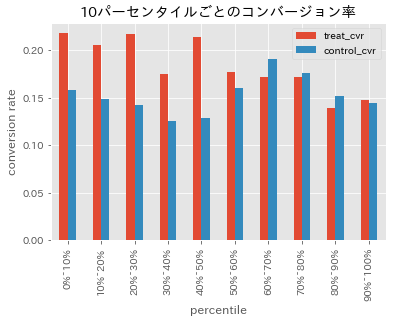

In [42]:
import matplotlib.pyplot as plt
plt.style.use('ggplot')

#10パーセンタイルのグラフを描く
qdf = pd.DataFrame(columns=('treat_cvr', 'control_cvr'))

quantile_data = []
for n in range(10):
    start = int(n * len(result) / 10)
    end = int((n + 1) * len(result) / 10) - 1
    quantiled_result = result[start:end]
    
    treat_uu = list(map(lambda item:item[1], quantiled_result)).count(True)
    control_uu = list(map(lambda item:item[1], quantiled_result)).count(False)
    
    treat_cv = [item[0] for item in quantiled_result if item[1] == True].count(True)
    control_cv = [item[0] for item in quantiled_result if item[1] == False].count(True)
    
    treat_cvr = treat_cv / treat_uu
    control_cvr = control_cv / control_uu
    
    quantile_data.append([treat_uu, control_uu, treat_cv, control_cv, treat_cvr, control_cvr])
        
    label = "{}%~{}%".format(n*10, (n+1)*10)
    qdf.loc[label] = [treat_cvr, control_cvr]

qdf.plot.bar()
plt.title("10パーセンタイルごとのコンバージョン率")
plt.xlabel("percentile")
plt.ylabel("conversion rate")


スコアの上位60%のセグメントでは、男性向けプッシュ通知(treat_cvr)が女性向けプッシュ通知よりもよく反応しています。よって、スコア上位60%には男性向け、下位40%には女性向けの配信を行うとよい。

In [0]:
df = pd.DataFrame(stat_data)
df.columns = ["is_cv", "is_treat", "score", "treat_uu", "control_uu", "treat_cv", "control_cv", "treat_cvr", "control_cvr", "lift"]

df["base_line"] = df.index * df["lift"][len(df.index) - 1] / len(df.index)

Text(0, 0.5, 'conversion count')

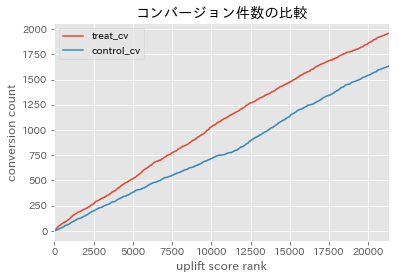

In [44]:
df.plot(y=["treat_cv", "control_cv"])
plt.title("コンバージョン件数の比較")
plt.xlabel("uplift score rank")
plt.ylabel("conversion count")

Text(0, 0.5, 'conversion rate')

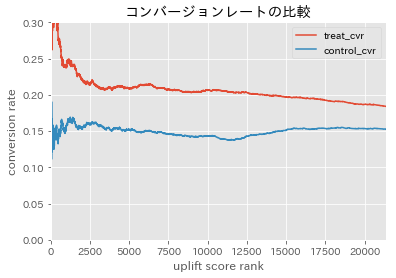

In [45]:
df.plot(y=["treat_cvr", "control_cvr"], ylim=[0, 0.3])
plt.title("コンバージョンレートの比較")
plt.xlabel("uplift score rank")
plt.ylabel("conversion rate")

Text(0, 0.5, 'lift count')

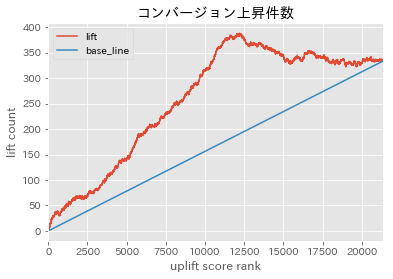

In [46]:
df.plot(y=["lift", "base_line"])
plt.title("コンバージョン上昇件数")
plt.xlabel("uplift score rank")
plt.ylabel("lift count")

In [39]:
#AUUCを算出する
auuc = (df["lift"] - df["base_line"]).sum() / len(df["lift"])
print("AUUC:", auuc)

AUUC: 89.6758108851996


Text(0, 0.5, 'conversion lift')

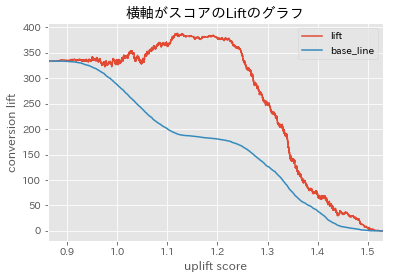

In [41]:
df.plot(x="score", y=["lift", "base_line"])
plt.title("横軸がスコアのLiftのグラフ")
plt.xlabel("uplift score")
plt.ylabel("conversion lift")

Uplift Modelingでは精度が高ければスコアの上位は実験群よりもコンバージョンする。
liftの曲線は最初のうちは実験群のコンバージョンが集まるため正の傾きをもち、最後では逆になる（lift曲線は精度が上がれば上がるほど、上に凸になり、liftとbase_lineに囲まれた面積が大きくなりAUUCスコアは大きくなる。

上記を踏まえ、liftが傾きはじめる場所は、約1.25。1.25以上のスコアの場合に施策を行うとよい。